<a href="https://colab.research.google.com/github/natasaivic/ml/blob/main/employee_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading libraries

In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

##Gather Data 

In [141]:
churn_data =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/WA_Fn-UseC_-HR-Employee-Attrition.csv')
churn_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [142]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

**Dataset Shape:** 
  * 35 columns 
  * 1470 rows 

**Data types:** 
  * int64(26)  
  * object(9)


In [143]:
churn_data.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

# Data pre-processing

In [144]:
numerical_cols = churn_data.columns[churn_data.dtypes=='int64'].tolist()

In [145]:
categorical_cols = churn_data.columns[churn_data.dtypes=='object'].tolist()
multi_valued_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() > 2].index.tolist()
# ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']

In [146]:
churn_data['BusinessTravel'].value_counts()
churn_data['Department'].value_counts()
churn_data['EducationField'].value_counts()
churn_data['JobRole'].value_counts()
churn_data['MaritalStatus'].value_counts()

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64

In [147]:
single_valued_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() == 1].index.tolist()
# ['Over18']

In [148]:
binary_colmmns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() == 2].index.tolist()
# ['Attrition', 'Gender', 'OverTime']

In [149]:
churn_data.drop(columns=single_valued_colmmns, inplace=True)

In [150]:
# Transform binary_columns
for column in binary_colmmns :
  churn_data[column] = LabelEncoder().fit_transform(churn_data[column])

In [151]:
# Transform multivalued columns
dummies_adjusted_data = pd.get_dummies(data = churn_data, columns=multi_valued_colmmns, drop_first=True)
dummies_adjusted_data

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,3,2,4,5993,19479,8,1,11,3,1,80,0,8,0,1,6,4,0,5,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,2,2,2,5130,24907,1,0,23,4,4,80,1,10,3,3,10,7,1,7,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,2,1,3,2090,2396,6,1,15,3,2,80,0,7,3,3,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,3,1,3,2909,23159,1,1,11,3,3,80,0,8,3,3,8,7,3,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,3,1,2,3468,16632,9,0,12,3,4,80,1,6,3,3,2,2,2,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,1,2061,3,1,41,4,2,4,2571,12290,4,0,17,3,3,80,1,17,3,3,5,2,0,3,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1466,39,0,613,6,1,1,2062,4,1,42,2,3,1,9991,21457,4,0,15,3,1,80,1,9,5,3,7,7,1,7,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1467,27,0,155,4,3,1,2064,2,1,87,4,2,2,6142,5174,1,1,20,4,2,80,1,6,0,3,6,2,0,3,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1468,49,0,1023,2,3,1,2065,4,1,63,2,2,2,5390,13243,2,0,14,3,4,80,0,17,3,2,9,6,0,8,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [152]:
# Z-Score normalization
numerical_columns = dummies_adjusted_data[numerical_cols]
scaled_numerical = numerical_columns.div(numerical_columns.mean(), axis=1)
scaled_numerical.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.00000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.247411,0.502824,0.881898,0.351593,0.0,0.587418,0.401607,0.308530,0.260652,0.536322,0.404184,0.723975,0.497292,0.927525,0.240635,0.114411,0.398640,0.0,1.07331,0.689811,0.460566,0.255856,0.874198,0.856685,1.472939,0.865395
min,0.487490,0.127105,0.108784,0.343298,1.0,0.000976,0.367408,0.455296,0.366309,0.484509,0.366492,0.155161,0.146300,0.000000,0.723231,0.951251,0.368698,1.0,0.00000,0.000000,0.000000,0.362158,0.000000,0.000000,0.000000,0.000000
25%,0.812484,0.579450,0.217568,0.686595,1.0,0.479331,0.734816,0.728474,0.732619,0.484509,0.732984,0.447644,0.562212,0.371306,0.788979,0.951251,0.737397,1.0,0.00000,0.531934,0.714459,0.724316,0.428072,0.472897,0.000000,0.485068
50%,0.974981,0.999395,0.761489,1.029893,1.0,0.995741,1.102224,1.001652,1.098928,0.969018,1.099476,0.756428,0.994578,0.742612,0.920476,0.951251,1.106095,1.0,1.25964,0.886557,1.071689,1.086475,0.713454,0.709345,0.457090,0.727603
75%,1.164560,1.441770,1.522978,1.373190,1.0,1.518004,1.469633,1.271036,1.098928,1.453527,1.465969,1.288496,1.429564,1.485224,1.183469,0.951251,1.474793,1.0,1.25964,1.329835,1.071689,1.086475,1.284217,1.655139,1.371269,1.697740
max,1.624968,1.867946,3.154740,1.716488,1.0,2.017826,1.469633,1.517654,1.465238,2.422544,1.465969,3.075382,1.886313,3.341753,1.643707,1.268335,1.474793,1.0,3.77892,3.546228,2.143378,1.448633,5.707630,4.256072,6.856343,4.123082


In [153]:
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(dummies_adjusted_data[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)
scaled

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,-0.057788,1.153254,-0.108350,0.726020,2.125136,-1.150554,-0.426230,-1.584178,0.0,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,-0.660853,-0.291719,1.488876,-0.678049,2.129306,2.346151,1.191438,0.0,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,-0.961486,0.246200,-0.937654,-1.674841,1.324226,-0.057267,-0.426230,-0.658973,0.0,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,-0.961486,0.246200,-0.763634,1.243211,-0.678049,-1.150554,-0.426230,0.266233,0.0,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,-0.660853,-0.644858,0.325900,2.525591,-0.877232,-0.426230,1.191438,0.0,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0.202082,1.703764,-0.891688,0.0,1.721670,0.254625,-1.224807,1.785511,-0.057788,1.153254,-0.835451,-0.284329,0.523316,0.489376,-0.426230,0.266233,0.0,0.241988,0.735447,0.155707,0.338096,-0.327893,-0.615492,-0.679146,-0.314873
1466,0.227347,-0.469754,-0.393938,-1.868426,0.0,1.723332,1.169781,-1.175601,-1.026167,0.845911,-1.567907,0.741140,1.004010,0.523316,-0.057267,-0.426230,-1.584178,0.0,0.241988,-0.293077,1.707500,0.338096,-0.001333,0.764998,-0.368715,0.806541
1467,-1.086676,-1.605183,-0.640727,0.085049,0.0,1.726655,-0.660531,1.038693,1.785511,-0.057788,-0.660853,-0.076690,-1.284418,-0.678049,1.309341,2.346151,-0.658973,0.0,0.241988,-0.678774,-2.171982,0.338096,-0.164613,-0.615492,-0.679146,-0.314873
1468,1.322365,0.546677,-0.887515,0.085049,0.0,1.728317,1.169781,-0.142264,-1.026167,-0.057788,-0.660853,-0.236474,-0.150393,-0.277594,-0.330589,-0.426230,1.191438,0.0,-0.932014,0.735447,0.155707,-1.077862,0.325228,0.488900,-0.679146,1.086895


In [154]:
scaled.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1470.0,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1470.0,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03
mean,-4.017950e-17,7.197568e-17,5.164048e-17,2.697011e-16,0.0,1.132881e-16,7.054070e-17,1.728021e-16,-6.495182e-18,1.479542e-16,-7.816876e-18,-5.403841e-17,2.394154e-17,-5.588878e-17,2.479498e-16,-7.766274e-16,-1.910792e-16,0.0,6.600918e-17,-9.236753e-17,-1.106069e-16,-5.165936e-17,-1.941002e-17,6.117555e-17,-4.236974e-17,-5.823006e-17
std,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,0.0,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,0.0,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00
min,-2.072192e+00,-1.736576e+00,-1.010909e+00,-1.868426e+00,0.0,-1.701283e+00,-1.575686e+00,-1.766079e+00,-2.432006e+00,-9.614864e-01,-1.567907e+00,-1.167343e+00,-1.717284e+00,-1.078504e+00,-1.150554e+00,-4.262300e-01,-1.584178e+00,0.0,-9.320144e-01,-1.450167e+00,-2.171982e+00,-2.493820e+00,-1.144294e+00,-1.167687e+00,-6.791457e-01,-1.155935e+00
25%,-7.581700e-01,-8.366616e-01,-8.875151e-01,-8.916883e-01,0.0,-8.866700e-01,-6.605307e-01,-8.803615e-01,-1.026167e+00,-9.614864e-01,-6.608532e-01,-7.632087e-01,-8.806440e-01,-6.780494e-01,-8.772324e-01,-4.262300e-01,-6.589728e-01,0.0,-9.320144e-01,-6.787735e-01,-6.201892e-01,-1.077862e+00,-6.544537e-01,-6.154916e-01,-6.791457e-01,-5.952272e-01
50%,-1.011589e-01,-1.204135e-03,-2.705440e-01,8.504925e-02,0.0,-7.253514e-03,2.546249e-01,5.355811e-03,3.796721e-01,-5.778755e-02,2.462002e-01,-3.365516e-01,-1.090645e-02,-2.775943e-01,-3.305891e-01,-4.262300e-01,2.662326e-01,0.0,2.419883e-01,-1.645114e-01,1.557071e-01,3.380962e-01,-3.278933e-01,-3.393937e-01,-3.687153e-01,-3.148735e-01
75%,6.653541e-01,8.788772e-01,5.932157e-01,1.061787e+00,0.0,8.821327e-01,1.169781e+00,8.787715e-01,3.796721e-01,8.459113e-01,1.153254e+00,3.986245e-01,8.641014e-01,5.233157e-01,7.626976e-01,-4.262300e-01,1.191438e+00,0.0,2.419883e-01,4.783162e-01,1.557071e-01,3.380962e-01,3.252275e-01,7.649976e-01,2.521455e-01,8.065415e-01
max,2.526886e+00,1.726730e+00,2.444129e+00,2.038524e+00,0.0,1.733302e+00,1.169781e+00,1.678377e+00,1.785511e+00,2.653309e+00,1.153254e+00,2.867626e+00,1.782888e+00,2.525591e+00,2.675949e+00,2.346151e+00,1.191438e+00,0.0,2.589994e+00,3.692454e+00,2.483396e+00,1.754054e+00,5.386914e+00,3.802074e+00,3.977310e+00,3.610079e+00


In [155]:
#dropping original values merging scaled values for numerical columns
dummies_adjusted_data = dummies_adjusted_data.copy()
data = dummies_adjusted_data.drop(columns = numerical_cols,axis = 1)
data = data.merge(scaled_numerical,left_index=True,right_index=True,how = "left")
data = data.drop(['EmployeeNumber'],axis = 1)
data

,Attrition,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1.110395,1.373233,0.108784,0.686595,1.0,0.734816,1.426595,1.098928,0.969018,1.465969,0.921584,1.360921,2.970447,0.723231,0.951251,0.368698,1.0,0.00000,0.709246,0.000000,0.362158,0.856144,0.945794,0.000000,1.212671
1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1.327057,0.347670,0.870273,0.343298,1.0,1.102224,0.925769,0.732619,0.969018,0.732984,0.788875,1.740154,0.371306,1.512210,1.268335,1.474793,1.0,1.25964,0.886557,1.071689,1.086475,1.426907,1.655139,0.457090,1.697740
2,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1.002063,1.710934,0.217568,0.686595,1.0,1.469633,1.396242,0.732619,0.484509,1.099476,0.321394,0.167399,2.227835,0.986224,0.951251,0.737397,1.0,0.00000,0.620590,1.071689,1.086475,0.000000,0.000000,0.000000,0.000000
3,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.893732,1.734610,0.326352,1.373190,1.0,1.469633,0.849886,1.098928,0.484509,1.099476,0.447337,1.618028,0.371306,0.723231,0.951251,1.106095,1.0,0.00000,0.709246,1.071689,1.086475,1.141526,1.655139,1.371269,0.000000
4,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.731235,0.736462,0.217568,0.343298,1.0,0.367408,0.607062,1.098928,0.484509,0.732984,0.533298,1.162012,3.341753,0.788979,0.951251,1.474793,1.0,1.25964,0.531934,1.071689,1.086475,0.285381,0.472897,0.914179,0.485068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0.974981,1.101577,2.502035,0.686595,1.0,1.102224,0.622238,1.465238,0.969018,1.465969,0.395360,0.858654,1.485224,1.117721,0.951251,1.106095,1.0,1.25964,1.507147,1.071689,1.086475,0.713454,0.472897,0.000000,0.727603
1466,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.056229,0.763877,0.652705,0.343298,1.0,1.469633,0.637415,0.732619,1.453527,0.366492,1.536384,1.499116,1.485224,0.986224,0.951251,0.368698,1.0,1.25964,0.797901,1.786148,1.086475,0.998835,1.655139,0.457090,1.697740
1467,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.731235,0.193150,0.435137,1.029893,1.0,0.734816,1.320359,1.465238,0.969018,0.732984,0.944497,0.361487,0.371306,1.314966,1.268335,0.737397,1.0,1.25964,0.531934,0.000000,1.086475,0.856144,0.472897,0.000000,0.727603
1468,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1.327057,1.274789,0.217568,1.029893,1.0,1.469633,0.956122,0.732619,0.969018,0.732984,0.828857,0.925236,0.742612,0.920476,0.951251,1.474793,1.0,0.00000,1.507147,1.071689,0.724316,1.284217,1.418691,0.000000,1.940274


# Multicollinearity

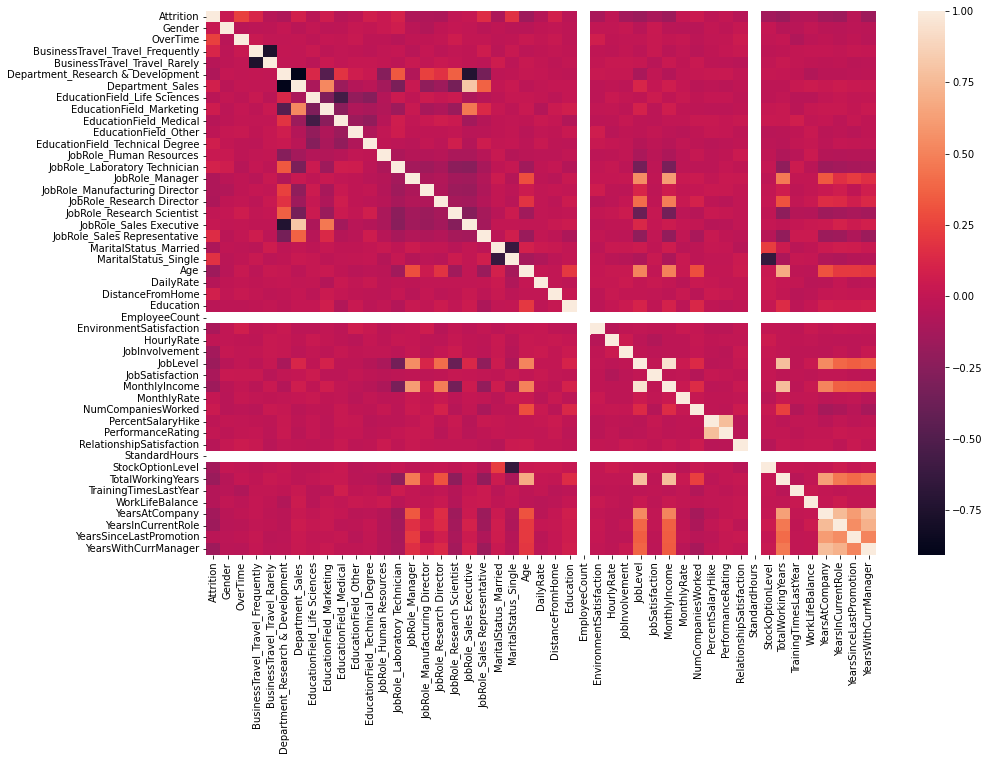

In [156]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

In [157]:
cols_to_melt = corr_matrix.columns
corr_matrix = corr_matrix.reset_index()

In [158]:
corr_matrix_melted = corr_matrix.melt( id_vars='index', value_vars=cols_to_melt)
corr_matrix_melted = corr_matrix_melted[corr_matrix_melted['index'] != corr_matrix_melted['variable']]
corrlations_above_threshold = corr_matrix_melted[corr_matrix_melted.value.abs() > .8]
columns_to_drop = corrlations_above_threshold['index'].to_list()
columns_to_drop

['Department_Sales',
 'Department_Research & Development',
 'JobRole_Sales Executive',
 'Department_Sales',
 'MonthlyIncome',
 'JobLevel']

In [159]:
data.drop(columns=columns_to_drop, inplace=True)

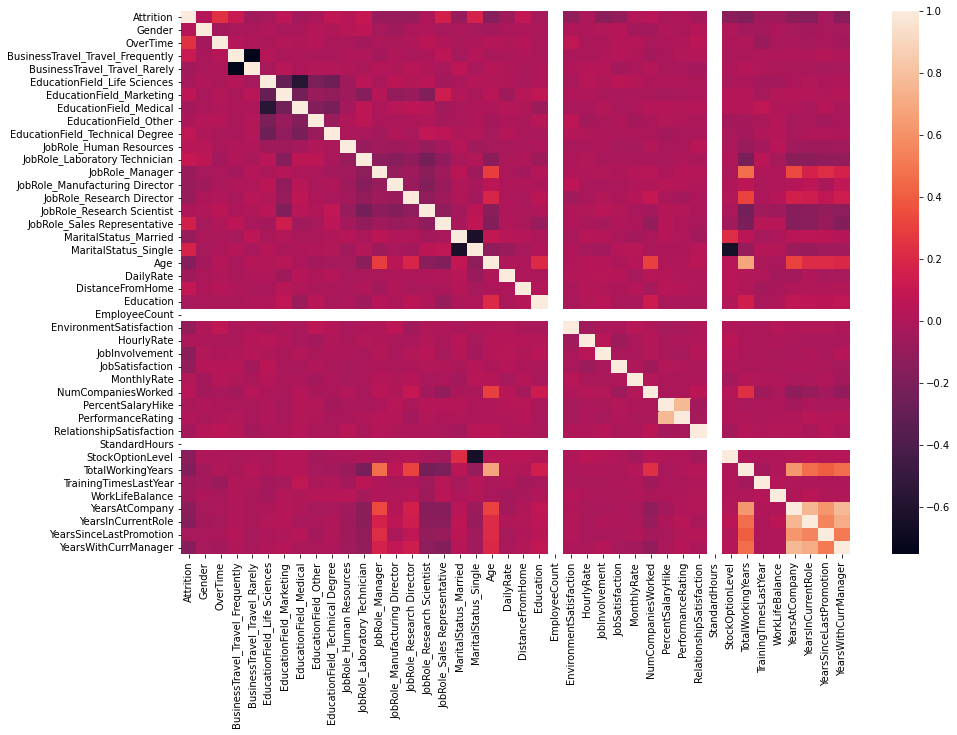

In [160]:
corr_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

# Unbalanced data

In [161]:
data.Attrition.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

In [162]:
positive_labels = data[data.Attrition==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

237

In [163]:
negative_labels = data[data.Attrition==0].sample(num_positive_labels)
negative_labels.shape

(237, 42)

In [164]:
balanced_data =  positive_labels.append(negative_labels)
balanced_data.Attrition.value_counts()

1    237
0    237
Name: Attrition, dtype: int64

# Splitting data into test splits

In [165]:
balanced_data.head()

,Attrition,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1.110395,1.373233,0.108784,0.686595,1.0,0.734816,1.426595,1.098928,1.465969,1.360921,2.970447,0.723231,0.951251,0.368698,1.0,0.0,0.709246,0.000000,0.362158,0.856144,0.945794,0.00000,1.212671
2,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1.002063,1.710934,0.217568,0.686595,1.0,1.469633,1.396242,0.732619,1.099476,0.167399,2.227835,0.986224,0.951251,0.737397,1.0,0.0,0.620590,1.071689,1.086475,0.000000,0.000000,0.00000,0.000000
14,1,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0.758318,0.128351,2.610819,1.029893,1.0,1.102224,0.758827,0.732619,1.099476,0.904556,1.856529,0.920476,0.951251,0.737397,1.0,0.0,0.531934,1.428919,1.086475,0.570763,0.472897,0.00000,0.727603
21,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0.974981,1.517784,0.979057,1.373190,1.0,1.102224,1.244477,0.732619,0.366492,0.488084,2.599141,1.512210,1.268335,0.737397,1.0,0.0,0.886557,1.428919,1.086475,0.713454,0.709345,0.00000,0.727603
24,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.920815,0.871044,0.652705,0.343298,1.0,0.734816,1.259653,1.098928,0.366492,1.194849,0.742612,0.723231,0.951251,1.106095,1.0,0.0,0.709246,0.714459,1.086475,0.570763,0.472897,0.45709,0.727603


In [166]:
y = balanced_data.pop('Attrition')
X = balanced_data

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [168]:
X_train.head()

,Gender,OverTime,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1443,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1.137477,0.373838,0.217568,1.029893,1.0,0.367408,0.849886,1.098928,1.099476,1.209521,1.856529,0.723231,0.951251,0.368698,1.0,0.00000,2.127737,0.714459,0.724316,3.139196,1.418691,1.828358,3.395479
214,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.812484,1.252359,0.326352,1.029893,1.0,1.469633,1.335536,1.098928,0.366492,0.597774,1.856529,0.723231,0.951251,1.106095,1.0,0.00000,0.709246,1.786148,1.086475,0.713454,0.472897,0.000000,0.970137
1077,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0.785401,0.279133,0.108784,1.373190,1.0,0.367408,1.517654,0.732619,0.366492,0.528746,2.227835,0.854728,0.951251,1.106095,1.0,0.00000,0.975213,0.714459,0.362158,1.284217,1.655139,0.000000,1.697740
498,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0.595822,0.752661,0.652705,0.343298,1.0,0.367408,1.047181,1.098928,1.099476,0.848523,0.000000,1.314966,1.268335,1.474793,1.0,0.00000,0.265967,1.071689,1.086475,0.285381,0.472897,0.914179,0.485068
1190,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0.866649,1.217467,0.217568,1.029893,1.0,1.469633,0.682944,1.098928,0.732984,1.782842,0.000000,0.854728,0.951251,1.106095,1.0,2.51928,0.886557,1.428919,0.724316,1.284217,1.182242,0.457090,1.455205


In [169]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

In [170]:
y_pred = clf.predict(X_test)

In [171]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,37,16
1,21,45


In [172]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Predicted,0,1,All
Actual,,,
0,37,16,53
1,21,45,66
All,58,61,119


0.8038879359634077


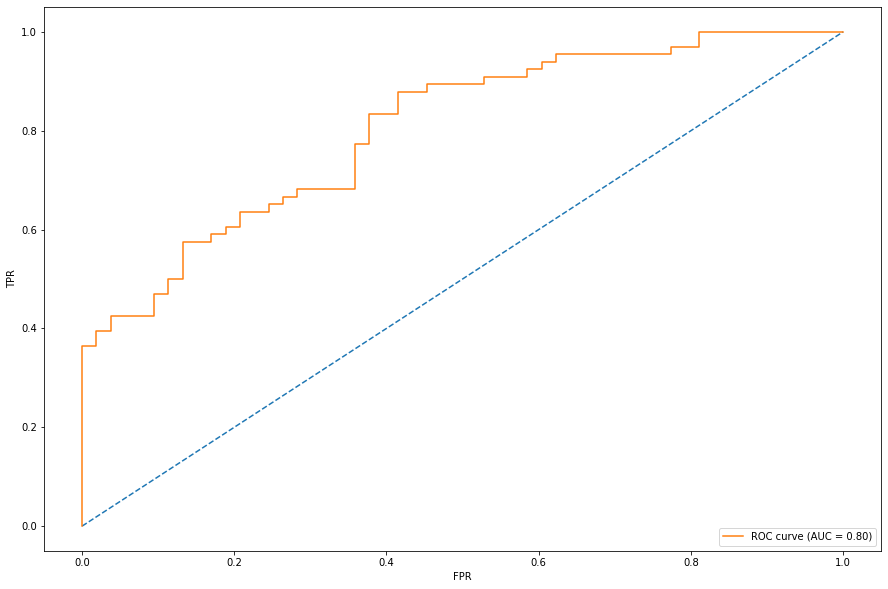

In [173]:
# calculate scores
auc = roc_auc_score(y_test, predictions)
print(auc)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

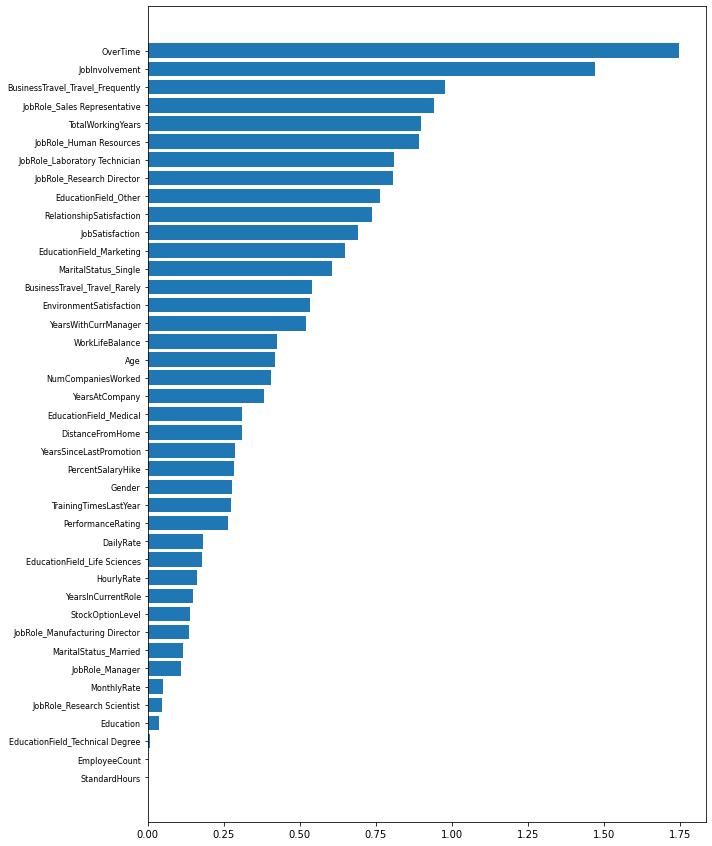

In [174]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()